# Partial dependence plots

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook we will use PDP to understand the relationship between a few features and a continuous target modeled with a linear regression.

We will make the plots using pandas, and overlay the count of observations over the PDP, to understand which areas of the plot we can trust.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Load data

In [2]:
# load the California House price data from Scikit-learn

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X = X.drop(columns=["Latitude", "Longitude"])

# scale the variables
X = MinMaxScaler().set_output(transform="pandas").fit_transform(X)

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,0.539668,0.784314,0.043512,0.020469,0.008941,0.001499
1,0.538027,0.392157,0.038224,0.018929,0.067210,0.001141
2,0.466028,1.000000,0.052756,0.021940,0.013818,0.001698
3,0.354699,1.000000,0.035241,0.021929,0.015555,0.001493
4,0.230776,1.000000,0.038534,0.022166,0.015752,0.001198


In [3]:
# split data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50)

## Linear Regression

In [4]:
# train model

linreg = LinearRegression().fit(X_train, y_train)

In [5]:
# R2 in train set

linreg.score(X_train, y_train)

0.5382828747778376

In [6]:
# R2 in test set

linreg.score(X_test, y_test)

0.5424083769532507

The model explains > 50% of the variability in the target.

## Coefficients - feature importance

Let's determine the feature importance derived from the model by looking at the coefficient's value.

More details on how to examine coefficients in the **Linear Regression** section.

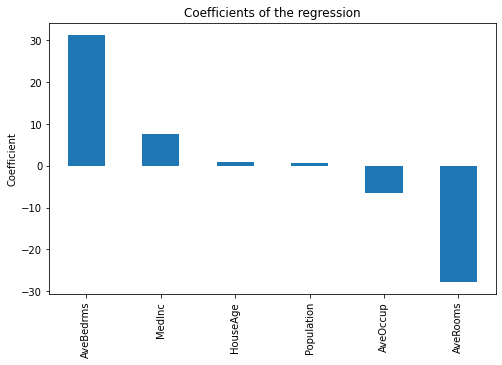

In [7]:
# put coefficients in a series

s = pd.Series(
    linreg.coef_,
    index = linreg.feature_names_in_,
)

# plot coefficients
s.sort_values(ascending=False).plot.bar(figsize=(8,5))
plt.title("Coefficients of the regression")
plt.ylabel("Coefficient")
plt.show()

## Partial dependence plots

We'll create the plots using pandas.

In [8]:
# Let's sort the variable into 10 bins

bins = pd.cut(X_test["MedInc"], bins=10)

bins

1945        (0.3, 0.4]
18006       (0.3, 0.4]
13062       (0.3, 0.4]
13396       (0.2, 0.3]
9787        (0.1, 0.2]
             ...      
2931     (-0.001, 0.1]
2060        (0.1, 0.2]
5224     (-0.001, 0.1]
15474       (0.1, 0.2]
13745       (0.3, 0.4]
Name: MedInc, Length: 6192, dtype: category
Categories (10, interval[float64, right]): [(-0.001, 0.1] < (0.1, 0.2] < (0.2, 0.3] < (0.3, 0.4] ... (0.6, 0.7] < (0.7, 0.8] < (0.8, 0.9] < (0.9, 1.0]]

The output contains the bins to which the observations were allocated.

In [9]:
# create dataframe with the data to analyse

# the mean is the value in the middle of each interval
# the count is the number of observations per interval

pdp = X_test.groupby(bins, observed=False)["MedInc"].agg(["mean", "count"])

pdp

,mean,count
MedInc,,
"(-0.001, 0.1]",0.071317,687
"(0.1, 0.2]",0.151476,2239
"(0.2, 0.3]",0.245746,1781
"(0.3, 0.4]",0.343794,919
"(0.4, 0.5]",0.442559,339
"(0.5, 0.6]",0.536766,126
"(0.6, 0.7]",0.652347,48
"(0.7, 0.8]",0.735646,25
"(0.8, 0.9]",0.850416,11


In [10]:
# Determine the PDP values to plot

pdp_preds = []

# we will set the values of MedInc in the test set
# to each one of the mean values within the intervals

for value in pdp["mean"]:
    
    # Set the feature to a fixed value
    X_test["MedInc"] = value
    
    # Obtain the predictions
    preds = linreg.predict(X_test)
    
    # get the prediction average
    pdp_preds.append(np.mean(preds))

# the predictions average
pdp_preds   

[0.8394230296558344,
 1.4528870255420119,
 2.1743461983155417,
 2.9247168543163693,
 3.6805812898616046,
 4.401554290277676,
 5.286113823229717,
 5.92360381940522,
 6.801958738802735,
 7.848329869384528]

In [11]:
# add the predictions to the pdp dataframe

pdp["pdp_preds"] = pdp_preds

pdp

,mean,count,pdp_preds
MedInc,,,
"(-0.001, 0.1]",0.071317,687,0.839423
"(0.1, 0.2]",0.151476,2239,1.452887
"(0.2, 0.3]",0.245746,1781,2.174346
"(0.3, 0.4]",0.343794,919,2.924717
"(0.4, 0.5]",0.442559,339,3.680581
"(0.5, 0.6]",0.536766,126,4.401554
"(0.6, 0.7]",0.652347,48,5.286114
"(0.7, 0.8]",0.735646,25,5.923604
"(0.8, 0.9]",0.850416,11,6.801959


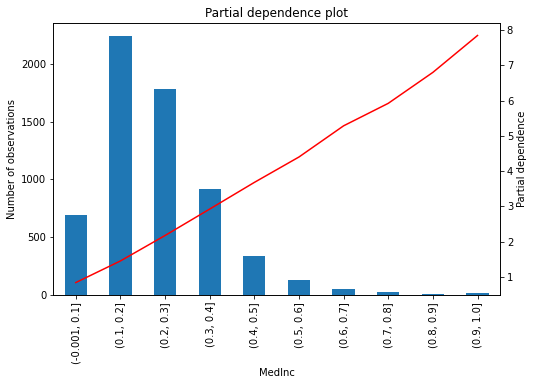

In [12]:
# Now we can plot the PDP over the count of 
# observations within each of the analysed intervals

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
ax2 = ax.twinx()

pdp["count"].plot.bar(ax=ax)
pdp["pdp_preds"].plot(ax=ax2, color="r")

plt.title("Partial dependence plot")
ax.set_ylabel("Number of observations")
ax2.set_ylabel("Partial dependence")
plt.show()

We observe the following:

- As expected, there is a linear association between MedInc and House price
- Most households show low MedInc, so we can trust the predictions for low MedInc better than those for higher MedInc.

In [13]:
# Let's put the code in a function

def plot_pdp(X, variable, bins=10):
    
    # to avoid modifying the original dataframe
    X = X.copy()
    
    # sort variable into bins
    bins = pd.cut(X[variable], bins=bins)
    
    # determine interval's middle point and n of observations
    pdp = X.groupby(bins, observed=False)[variable].agg(["mean", "count"])
    
    # calculate partial dependence
    pdp_preds = []
    for value in pdp["mean"]:
        X[variable] = value
        preds = linreg.predict(X)
        pdp_preds.append(np.mean(preds))
    pdp["pdp_preds"] = pdp_preds
    
    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax2 = ax.twinx()

    pdp["count"].plot.bar(ax=ax)
    pdp["pdp_preds"].plot(ax=ax2, color="r")

    plt.title(f"Partial dependence plot - {variable}")
    ax.set_ylabel("Number of observations")
    ax2.set_ylabel("Partial dependence")
    plt.show()

In [14]:
# split data again, because we modified the test
# set in previous cells.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50)

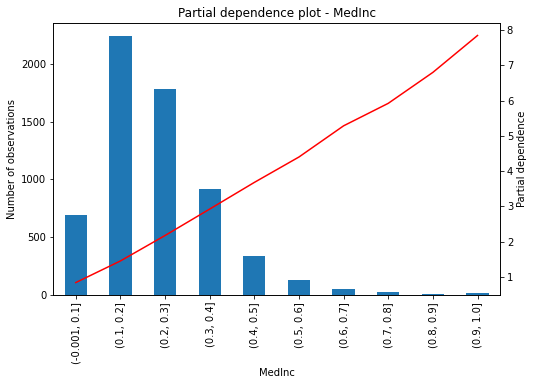

In [15]:
# test the function

plot_pdp(X_test, "MedInc")

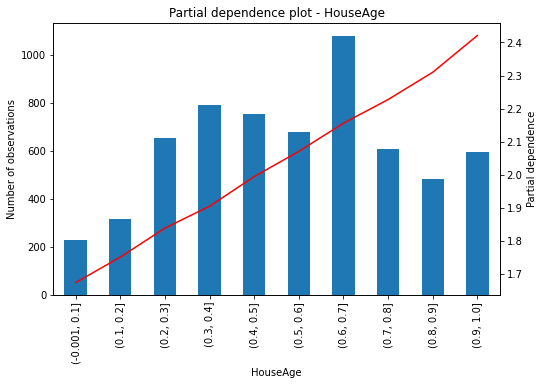

In [16]:
# Analyse a different variable

plot_pdp(X_test, "HouseAge")

For HouseAge we see again a linear increase, which was expected given that we trained a linear model. The increase in house price is smaller. And we have a more homogeneous spread of House Ages in our data, so in principle, we could trust the predictions across all bins.

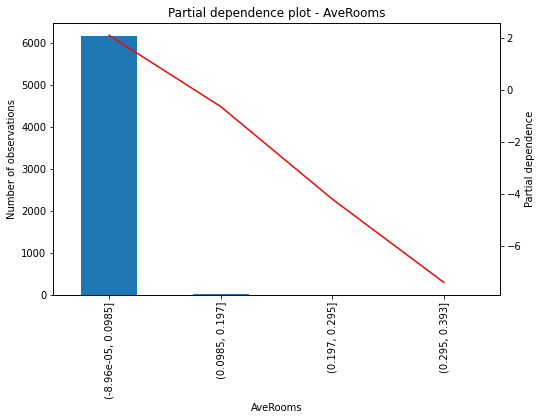

In [17]:
# Analyse a different variable

# These variable is so skewed, that we need less bins
# otherwise most bins will be empty, and we'll get an error

plot_pdp(X_test, "AveRooms", bins=4)

The variable AveRooms is very skewed. Most houses contain few rooms. Hence, we don't get a useful view from this PDP.

When we have very skewed variables, it might be more useful designing the bins to contain equal number of observations, instead of being equidistant.

Below a suitable alternative:

In [18]:
# Let's put the code in a function

def plot_pdp(X, variable, bins=10):
    
    # to avoid modifying the original dataframe
    X = X.copy()
    
    # sort variable into bins with equal n of obs.
    bins = pd.qcut(X[variable], q=bins)
    
    # determine interval's middle point and n of observations
    pdp = X.groupby(bins, observed=False)[variable].agg(["mean", "count"])
    
    # calculate partial dependence
    pdp_preds = []
    for value in pdp["mean"]:
        X[variable] = value
        preds = linreg.predict(X)
        pdp_preds.append(np.mean(preds))
    pdp["pdp_preds"] = pdp_preds
    
    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax2 = ax.twinx()

    pdp["count"].plot.bar(ax=ax)
    pdp["pdp_preds"].plot(ax=ax2, color="r")

    plt.title(f"Partial dependence plot - {variable}")
    ax.set_ylabel("Number of observations")
    ax2.set_ylabel("Partial dependence")
    plt.show()

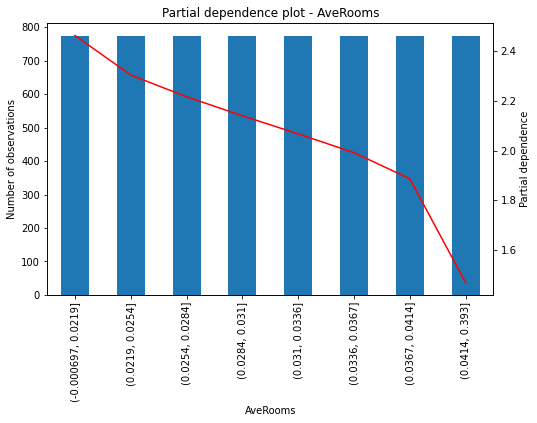

In [19]:
# Analyse a different variable

plot_pdp(X_test, "AveRooms", bins=8)

There seems to be a linear relationship up to the previous to last bucket. Then, the price seems to decrease drastically.

The advantage of making this plots manually, is that we can determine both the partial dependence and the number of observations per interval.

Scikit-learn has a function to plot PDP, but it misses a key piece of information, which is the number of observations per interval. Hence, we are blind, we don't know how confident we should be about a certain point.